# Variational Quantum State Tomography using pennylane

Variational methods have a wide range of application in optimization and machine learning. However, they can also be used to study quantum computers. Currently, we are in an era where quantum computers present a large amount of noise due to the low number of qubits (<100) and the low fidelity of the gates. In this era, known as the noisy intermediate-scale quantum (NISQ), characterizing how quantum devices work is critical, since they allow us to understand and improve the available quantum devices. One way to achieve this is through quantum tomography. This consists of protocols that allow obtaining the quantum state of a system, which can be a prior unknown. In this notebook we will implement a variational tomographic method for pure quantum states, based on https://arxiv.org/abs/1406.4101. We start with an introduction to the problem of estimating quantum states, then we explain the method and its optimization algorithm and we finish with the implementation of the problem using pennylane. 

## Quantum state tomography

The most general way to represent a quantum state is through a semi-definite positive and trace one matrix known as density operator

$$
\rho = \frac{1}{2^n}\sum_{j_1,\dots,j_n} S_{j_1,\dots,j_n} \sigma_{j_1}\otimes\cdots\otimes\sigma_{j_n},
$$

where $\{S_{j_1,\dots,j_n} \}$ are real parameters and $\{\sigma_{j}\}$ are the Pauli matrices. The aim of quantum tomography methods is to obtain the parameters $\{S_{j_1,\dots,j_n} \}$. This can be achieved by measuring $3^n-1$ observables given by tensor products of the Pauli matrices 

$$
S_{j_1,\dots,j_n} =  \langle \sigma_{j_1}\otimes\cdots\otimes\sigma_{j_n} \rangle .
$$

This method is widely used, and has been implemented up to 8 qubits. However, since the number of measurements scales exponentially with dimension, the problem quickly becomes intractable. This protocol is widely used, and has been implemented up to 8 qubits. However, since the number of measurements scales exponentially with dimension, the problem quickly becomes intractable. 

## Variational quantum state tomography

Several alternatives have been proposed to perform quantum state tomography efficiently for state of large number of qubits. One of them is the Variational Quantum Tomography (VQT), which works throught the maximization of the quantum fidelity $f = |\langle \phi |\psi\rangle|^2$ between the unknown state $|\psi\rangle $ of some system and one eigenvector $|\phi\rangle $ of a measurement operator, using Simultaneous perturbation stochastic approximation (SPSA), a well-known classical optimization algorithm. The main feature of SPSA for tomography is that it uses an aproximation of the gradient of the fidelity, instead of the exact one. This is crucial in our case, because the fidelity can be estimated experimentally, but its gradient cannot.

If $|\phi \rangle $ depends on the parameters $\boldsymbol{\theta} \in \mathbb{R}^n$ and we are at iteration $k$, we

   (1) Generate a random direction to search given by $\boldsymbol{\Delta}_k \in \{-1, 1\}^n$.

   (2) Calculate the estimated gradient in that direction, $\boldsymbol{g}_k = \frac{f(\theta_k + \Delta_k \beta_k) - f(\theta_k - \Delta_k \beta_k) }{2 \beta_k} \boldsymbol{\Delta}_k$.

   (3) Calculate the next iterate via $\boldsymbol{\theta}_{k+1} = \boldsymbol{\theta}_{k} + \alpha_k \boldsymbol{g}_k$,

with $\alpha_k$ and $\beta_k$ functions of $k$ that control the convergence of the method. Then, in a sufficient number of iterations the estimate $|\phi (\boldsymbol{\theta}) \rangle$ is very close to the true state of the system $|\psi\rangle$, but not the same because of the shot noise of the measurements, as is usual in any tomographic method. Since SPSA employ two measurements of the Fidelity per iteration, the total number of measurements requiered by VQT is $2\times$(Number of iterations), which can be not exponential in the number of qubits choosing suitably the number of iterations. Rambatch et al show in https://arxiv.org/pdf/2010.00632.pdf that tomography by optimization is more robust to experimental noise than tomography by estimation, which is really interesting for the NISQ computation. 

In [1]:
import pennylane as qml    
from pennylane import numpy as np                           
import matplotlib.pyplot as plt  

We first implement SPSA. By construction, it can be used like any other optimization method in pennylane.

In [2]:
class SPSA:
    
    def __init__(self, a=3 , c=0.01, A=0, α=0.602 , γ=0.101):
        self._a = a
        self._c = c
        self._A = A
        self._α = α
        self._γ = γ
        
    def step(self, function, θ, k):
        
        ak = self._a/(k+self._A+1)**self._α, 
        ck = self._c/(k+1)**self._γ
                
        Δ  = 2*np.round(np.random.rand(θ.size).reshape(θ.shape)) - 1
        
        θ_plus  = θ + ck*Δ
        θ_minus = θ - ck*Δ   
        
        function_plus  = function(θ_plus)  
        function_minus = function(θ_minus)  
        
        ghat = np.divide(function_plus-function_minus, 2*ck*Δ + 1e-8)
        
        return θ - ak*ghat 

We set the number of qubits and the optimization algorithm. 

In [3]:
num_qubits = 5
opt = SPSA(a=2, c=0.1)
max_iterations = 1000
np.random.seed(129464)

We want to compare the performance of the method evaluating the fidelity analitically and experimentally. Then we initialize two devices. 

In [4]:
dev_an = qml.device("default.qubit", wires=num_qubits, analytic=True)
dev_st = qml.device("default.qubit", wires=num_qubits, analytic=False)

As an example, we will simulate the VQT of a GHZ state. This is a highly entangled state, and is a common benchmark for tomography. We will perform the tomography using three different variational forms: local, matrix product state like and dense.

<img src="Circuit_figures/GHZ.jpg" width="400" height="200">

In [5]:
def GHZ_State(n_wires):
    qml.Hadamard(wires = 0)
    qml.broadcast(qml.CNOT, wires=range(n_wires), pattern="chain")

### 1. Local variational form

There are several variational forms that we can choose. The simplest one is a set of local rotations in each qubit. In this case, we will find the closest separable state to the GHZ.

<img src="Circuit_figures/Variational_Local.jpg" width="400" height="200">

In [6]:
def Variational_circuit_local(params, n_wires):
    qml.broadcast(qml.RY, wires=range(n_wires), pattern="single", parameters = params) 

In [7]:
@qml.qnode(dev_an)
def Fidelity_analytic(params):
    n_wires = dev_an.num_wires
    GHZ_State(n_wires)
    Variational_circuit_local(params, n_wires)
    return qml.probs(wires=range(n_wires))

@qml.qnode(dev_st)
def Fidelity_stochastic(params):
    n_wires = dev_st.num_wires
    GHZ_State(n_wires)
    Variational_circuit_local(params, n_wires)
    return qml.probs(wires=range(n_wires))

We minimize the analytic and experimental infidelities. This is the same as maximizing the fidelity, because $inf(\theta) = 1-f(\theta)$

In [8]:
infids_an = []
infids_st = []
params    = .25*np.ones(num_qubits)
fun_an    = lambda params : 1 - Fidelity_analytic(params)[0]
fun_st    = lambda params : 1 - Fidelity_stochastic(params)[0]

for n in range(max_iterations):
    params = opt.step( fun_st, params, n )
    infids_an.append( fun_an(params) )
    infids_st.append( fun_st(params) )

print()
print( 'final fidelity = ', 1-infids_an[-1] )
print()


final fidelity =  0.4976544894933157



Finally, we plot the infidelity for each iteration of the algorithm. Since the variational form is a separable state, the algorithm converges to $|00\rangle$ or $|11\rangle$ with equal probability, and then the minimum infidelity is 0.5

Text(0, 0.5, 'Infidelity')

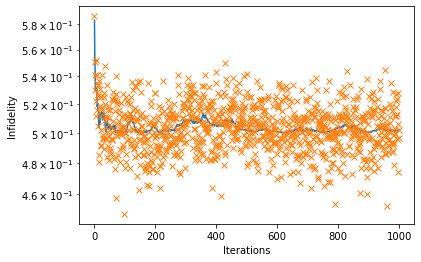

In [9]:
plt.plot(infids_an)
plt.plot(infids_st , 'x')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Infidelity')

### 2. Matrix product state variational form

Now we change our variational form to a matrix product state (MPS). If the system has a low correlation distance, that is, the qubits only interact with their closest neighbors, the state can be efficiently represented through an MPS. So using an MPS would be a good choice if we know some information about the system. 

<img src="Circuit_figures/Variational_mps.jpg" width="600" height="300">

In [10]:
@qml.template
def single_layer_MPS(parameters, wires):
    qml.RY(parameters[0], wires = wires[0])
    qml.CNOT(wires = wires)
    qml.RY(parameters[1], wires = wires[0])
    qml.RY(parameters[2], wires = wires[1])

@qml.template
def Variational_circuit_MPS(params, n_wires):
    qml.RY(params[0], wires = n_wires-1)
    params = params[:-1].reshape(n_wires-1,3)
    for k in reversed(range(n_wires-1)) :
        single_layer_MPS(params[k] , [k,k+1])

In [11]:
@qml.qnode(dev_an)
def Fidelity_analytic(params):
    n_wires = dev_an.num_wires
    GHZ_State( n_wires )
    Variational_circuit_MPS(params, n_wires)
    return qml.probs(wires=range(n_wires))

@qml.qnode(dev_st)
def Fidelity_stochastic(params):
    n_wires = dev_st.num_wires
    GHZ_State( n_wires )
    Variational_circuit_MPS(params, n_wires)
    return qml.probs(wires=range(n_wires))

In [12]:
infids_an = []
infids_st = []
params    = .25*np.ones(3*num_qubits-2)
fun_an    = lambda params : 1 - Fidelity_analytic(params)[0]
fun_st    = lambda params : 1 - Fidelity_stochastic(params)[0]

for n in range(max_iterations):
    params = opt.step(fun_st, params, n)
    infids_an.append(fun_an(params))
    infids_st.append(fun_st(params))

print()
print('final fidelity = ', 1-infids_an[-1])
print()



final fidelity =  0.9997434642954134



We see in the following plot that the distance between the true state and the estimate drops to around $10^{-3}$, but reaches a plateau in the case of the experimental fidelity. This is because of the shot noise. 

Text(0, 0.5, 'Infidelity')

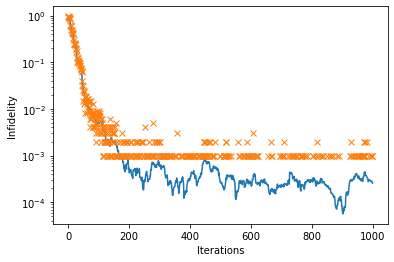

In [13]:
plt.plot(infids_an)
plt.plot(infids_st , 'x')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Infidelity')

### 3. Dense variational form

Finally, we allow the parameters of $| \phi \rangle$ to be completely free using a dense layer. This is useful if we do not know anything about the unknown state. 

<img src="Circuit_figures/Variational_dense.jpg" width="600" height="300">

In [14]:
def single_layer_dense(W):
    n_wires  = W.shape[0]
    qml.broadcast(qml.RY, wires=range(n_wires), pattern="single", parameters = W) 
    qml.broadcast(qml.CNOT, wires=range(n_wires), pattern="all_to_all")

def Variational_circuit_dense(params, wires):
    n_layers = params.shape[0]-1
    n_wires = params.shape[1]
    qml.layer(single_layer_dense, n_layers, params[:n_layers])
    qml.broadcast(qml.RY, wires=range(n_wires), pattern="single", parameters = params[n_layers]) 


In [15]:
@qml.qnode(dev_an)
def Fidelity_analytic(params):
    n_wires = dev_an.num_wires
    GHZ_State( n_wires )
    Variational_circuit_dense(params, n_wires)
    return qml.probs(wires=range(n_wires))

@qml.qnode(dev_st)
def Fidelity_stochastic(params):
    n_wires = dev_st.num_wires
    GHZ_State( n_wires )
    Variational_circuit_dense(params, n_wires)
    return qml.probs(wires=range(n_wires))

In [16]:
infids_an = []
infids_st = []
num_layers= num_qubits
params    = np.zeros((num_layers,num_qubits))
fun_an    = lambda params : 1 - Fidelity_analytic(params)[0]
fun_st    = lambda params : 1 - Fidelity_stochastic(params)[0]

for n in range(max_iterations):
    params = opt.step(fun_st, params, n)
    infids_an.append(fun_an(params))
    infids_st.append(fun_st(params))

print()
print('final fidelity = ', 1-infids_an[-1])
print()



final fidelity =  0.9992443844511494



We see that the fidelity is almost the same that using an MPS. This is because the choise of a GHZ state as a benchmark for the protocol. This state can be eficientelly represented using an MPS.

Text(0, 0.5, 'Infidelity')

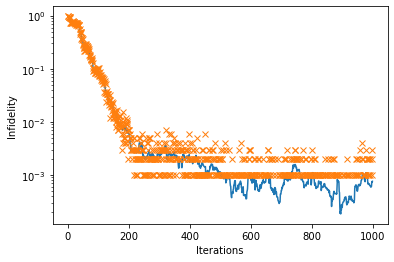

In [17]:
plt.plot(infids_an)
plt.plot(infids_st , 'x')
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Infidelity')